## Part VII.3 - Register and Deploy Best DeepAR model 

University of San Diego - MS Applied AI

AAI-540 Team 5

October 21, 2024

In [103]:
# setup environment
%run 0-Environment_Setup.ipynb

Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


### Store Best DeepAR Model to Registry

In [7]:
# Load the best model information from our tuning job
tuning_job_name = "deepar-hyperparamete-241007-2220"
tuning_job_result = sm.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

# get model details from best training job
best_training_job_name = tuning_job_result["BestTrainingJob"]["TrainingJobName"]
best_training_job = sm.describe_training_job(TrainingJobName=best_training_job_name)
best_model_path = best_training_job['ModelArtifacts']['S3ModelArtifacts']
best_model_path

's3://sagemaker-us-east-1-343218227212/store-sales-forecasting/deepar/gold-dataset/output/deepar-hyperparamete-241007-2220-007-b18b6b1e/output/model.tar.gz'

In [4]:
# Setup Model Group for our DeepAR Store Sales Prediction Models
model_package_group_name = "deepar-store-sales-prediction"
model_package_group_input_dict = {
 "ModelPackageGroupName" : model_package_group_name,
 "ModelPackageGroupDescription" : "Model group for DeepAR grocery store forecasting models."
}

# Create the group
create_model_package_group_response = sm.create_model_package_group(**model_package_group_input_dict)
print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:343218227212:model-package-group/deepar-store-sales-prediction


In [6]:
# display the result
response = sm.describe_model_package_group(
    ModelPackageGroupName=model_package_group_name
)
response

{'ModelPackageGroupName': 'deepar-store-sales-prediction',
 'ModelPackageGroupArn': 'arn:aws:sagemaker:us-east-1:343218227212:model-package-group/deepar-store-sales-prediction',
 'ModelPackageGroupDescription': 'Model group for DeepAR grocery store forecasting models.',
 'CreationTime': datetime.datetime(2024, 10, 8, 23, 4, 53, 217000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:343218227212:user-profile/d-nzj1ohif3tlp/default-20241007T091581',
  'UserProfileName': 'default-20241007T091581',
  'DomainId': 'd-nzj1ohif3tlp',
  'IamIdentity': {'Arn': 'arn:aws:sts::343218227212:assumed-role/AmazonSageMaker-ExecutionRole-20241007T091581/SageMaker',
   'PrincipalId': 'AROAU72LGRAGGJLCV6WF3:SageMaker'}},
 'ModelPackageGroupStatus': 'Completed',
 'ResponseMetadata': {'RequestId': '69ceb40c-530e-4dac-9eeb-16795d122c1c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '69ceb40c-530e-4dac-9eeb-16795d122c1c',
   'content-type': 'application/x-amz

In [8]:
# Setup Model Package
model_url = best_model_path
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", region)

modelpackage_inference_specification =  {
    "InferenceSpecification": {
      "Containers": [
         {
            "Image": image_uri,
	         "ModelDataUrl": model_url
         }
      ],
      "SupportedContentTypes": [ "application/json" ],
      "SupportedResponseMIMETypes": [ "application/json" ],
   }
 }

create_model_package_input_dict = {
    "ModelPackageGroupName" : model_package_group_name,
    "ModelPackageDescription" : "Daily forecasting of sales of Favorita grocery stores by store number.",
    "ModelApprovalStatus" : "PendingManualApproval"
}
create_model_package_input_dict.update(modelpackage_inference_specification)

In [10]:
# create the model package
create_model_package_response = sm.create_model_package(**create_model_package_input_dict)
model_package_arn = create_model_package_response["ModelPackageArn"]
print('ModelPackage Version ARN : {}'.format(model_package_arn))

ModelPackage Version ARN : arn:aws:sagemaker:us-east-1:343218227212:model-package/deepar-store-sales-prediction/1


In [12]:
# display the result
response = sm.describe_model_package(
    ModelPackageName=model_package_arn
)
response

{'ModelPackageGroupName': 'deepar-store-sales-prediction',
 'ModelPackageVersion': 1,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:343218227212:model-package/deepar-store-sales-prediction/1',
 'ModelPackageDescription': 'Daily forecasting of sales of Favorita grocery stores by store number.',
 'CreationTime': datetime.datetime(2024, 10, 8, 23, 13, 31, 770000, tzinfo=tzlocal()),
 'InferenceSpecification': {'Containers': [{'Image': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1',
    'ImageDigest': 'sha256:95f378cab0150199a973700ad55a52a9bd64c27ca8c8c7ee717ee67b371ac1f2',
    'ModelDataUrl': 's3://sagemaker-us-east-1-343218227212/store-sales-forecasting/deepar/gold-dataset/output/deepar-hyperparamete-241007-2220-007-b18b6b1e/output/model.tar.gz'}],
  'SupportedContentTypes': ['application/json'],
  'SupportedResponseMIMETypes': ['application/json']},
 'ModelPackageStatus': 'Completed',
 'ModelPackageStatusDetails': {'ValidationStatuses': [],
  'ImageScanStatuses':

### Create Model Card

In [13]:
from sagemaker import model_card

In [17]:
model_name = "deepar-hyperparamete-241007-2220-007-b18b6b1e"

# define model overview
model_overview = model_card.ModelOverview.from_model_name(
    model_name=model_name,
    sagemaker_session=sess,
    model_description="DeepAR forecasting model trained to forecast daily sales for Favorita grocery stores.  This is a multi-timeseries model that can forecast sales at the store level for all 54 stores.",
    problem_type="Time series forecasting/regression",
    algorithm_type="DeepAR",
    model_creator="AAI-540-FA24-Team5",
    model_owner="AAI-540-FA24-Team5",
)

training_details = model_card.TrainingDetails.from_model_overview(
    model_overview=model_overview,
    sagemaker_session=sess,
    training_observations="RMSE on validation data was reasonable and model did a fair job converging.",
)

my_metric_group = model_card.MetricGroup(
    name="Time series forecasting metrics",
    metric_data=[model_card.Metric(name="RMSE", type='number', value=3434.86)]
)

intended_uses = model_card.IntendedUses(
    purpose_of_model="Store level forecasting of daily sales.",
    intended_uses="For educational purposes only.",
    factors_affecting_model_efficiency="Model does not handle seasonality spikes very well.",
    risk_rating=model_card.RiskRatingEnum.LOW,
    explanations_for_risk_rating="Model is experimental only.",
)

evaluation_details = [
    model_card.EvaluationJob(
        name=model_name,
        evaluation_observation="Model generalizes reasonably well to the test dataset.",
        datasets=["s3://sagemaker-us-east-1-343218227212/store-sales-forecasting/deepar/gold-dataset/train/train.json","s3://sagemaker-us-east-1-343218227212/store-sales-forecasting/deepar/gold-dataset/val/val.json"],
    )
]

In [18]:
# create the model card
model_card_name = "deepar-store-sales-prediction"
my_card = model_card.ModelCard(
    name=model_card_name,
    status=model_card.ModelCardStatusEnum.APPROVED,
    model_overview=model_overview,
    training_details=training_details,
    intended_uses=intended_uses,
    evaluation_details=evaluation_details,
    sagemaker_session=sess,
)
my_card.create()

'arn:aws:sagemaker:us-east-1:343218227212:model-card/deepar-store-sales-prediction'

In [20]:
# display model card 
response = sm.describe_model_card(
    ModelCardName=model_card_name,
)
response

{'ModelCardArn': 'arn:aws:sagemaker:us-east-1:343218227212:model-card/deepar-store-sales-prediction',
 'ModelCardName': 'deepar-store-sales-prediction',
 'ModelCardVersion': 1,
 'Content': '{"model_overview": {"model_id": "arn:aws:sagemaker:us-east-1:343218227212:model/deepar-hyperparamete-241007-2220-007-b18b6b1e", "model_name": "deepar-hyperparamete-241007-2220-007-b18b6b1e", "model_description": "DeepAR forecasting model trained to forecast daily sales for Favorita grocery stores.  This is a multi-timeseries model that can forecast sales at the store level for all 54 stores.", "problem_type": "Time series forecasting/regression", "algorithm_type": "DeepAR", "model_creator": "AAI-540-FA24-Team5", "model_owner": "AAI-540-FA24-Team5", "model_artifact": ["s3://sagemaker-us-east-1-343218227212/store-sales-forecasting/deepar/gold-dataset/output/deepar-hyperparamete-241007-2220-007-b18b6b1e/output/model.tar.gz"], "inference_environment": {"container_image": ["522234722520.dkr.ecr.us-east-1

### Create Endpoint for our Best DeepAR Model

In [21]:
# Create Endpoint Configuration
best_model_name = 'deepar-hyperparamete-241007-2220-007-b18b6b1e'
endpoint_config_name = 'deepar-store-sales-forecasting-config'

instance_type = 'ml.m5.xlarge'

endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name, 
    # List of ProductionVariant objects, one for each model that you want to host at this endpoint.
    ProductionVariants=[
        {
            "VariantName": "variant1", # The name of the production variant.
            "ModelName": best_model_name, 
            "InstanceType": instance_type, # Specify the compute instance type.
            "InitialInstanceCount": 1 # Number of instances to launch initially.
        }
    ]
)

print(f"Created EndpointConfig: {endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:us-east-1:343218227212:endpoint-config/deepar-store-sales-forecasting-config


In [23]:
# Deploy our best model to real-time endpoint
endpoint_name = 'deepar-store-sales-forecasting-realtime'
create_endpoint_response = sm.create_endpoint(
                                            EndpointName=endpoint_name, 
                                            EndpointConfigName=endpoint_config_name) 

In [27]:
# Wait for endpoint to spin up
import time 
sm.describe_endpoint(EndpointName=endpoint_name)

while True:
    print("Getting Job Status")
    res = sm.describe_endpoint(EndpointName=endpoint_name)
    state = res["EndpointStatus"]
    
    if state == "InService":
        print("Endpoint in Service")
        break
    elif state == "Creating":
        print("Endpoint still creating...")
        time.sleep(20)
    else:
        print("Endpoint Creation Error - Check Sagemaker Console")
        break

Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint in Service


### Test the endpoint

In [83]:
#from sagemaker.serializers import json_serializer
from sagemaker.base_serializers import JSONSerializer, IdentitySerializer
from sagemaker.base_deserializers import JSONDeserializer

In [84]:
# create predictor for real time
json_serializer = JSONSerializer()
predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name, 
    sagemaker_session=sess, 
    serializer=IdentitySerializer(content_type="application/json"),
    deserializer=JSONDeserializer(),
    content_type="application/json")

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [30]:
# setup variables
input_data_path = "{}/test/test.json".format(s3_deepar_gold_dataset_path)
inference_filename = "test.json"
input_local_filename = f"results/test-transform/{inference_filename}"

In [29]:
# copy test dataset to local path
!aws s3 cp $input_data_path ./results/test-transform/

download: s3://sagemaker-us-east-1-343218227212/store-sales-forecasting/deepar/gold-dataset/test/test.json to results/test-transform/test.json


In [85]:
# load test data
test_input = load_json_by_line(input_local_filename)

In [111]:
# create inference input from test sample
def create_deepar_input_from_test(test_sample):
    test_data = {
        "instances": [
            test_sample
        ],
        "configuration": {
            "output_types": ["mean"]
        }
    }
    return json.dumps(test_data).encode('utf-8')

# helper function to compile dataset of inputs + forecasts
def build_deepar_forecast_df(input_data, predictions, start_date):
    forecasts = []
    current_date = pd.to_datetime(start_date)
    for input_step in input_data:
        forecasts.append([current_date, input_step, 0])
        current_date = current_date + datetime.timedelta(days=1)
    for prediction in predictions:
        forecasts.append([current_date, 0, prediction])
        current_date = current_date + datetime.timedelta(days=1)

    forecast_df = pd.DataFrame(columns=['date', 'true_sales', 'predicted_sales'], data=forecasts)
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])
    return forecast_df

In [195]:
# run prediction on a random sample input
sample_idx = random.randint(0, len(test_input))
result = predictor.predict(create_deepar_input_from_test(test_input[sample_idx]))

In [196]:
# post process results
store_forecast = build_deepar_forecast_df(test_input[sample_idx]['target'],result['predictions'][0]['mean'], test_input[sample_idx]['start'])
store_nbr = test_input[sample_idx]['cat'][0] + 1

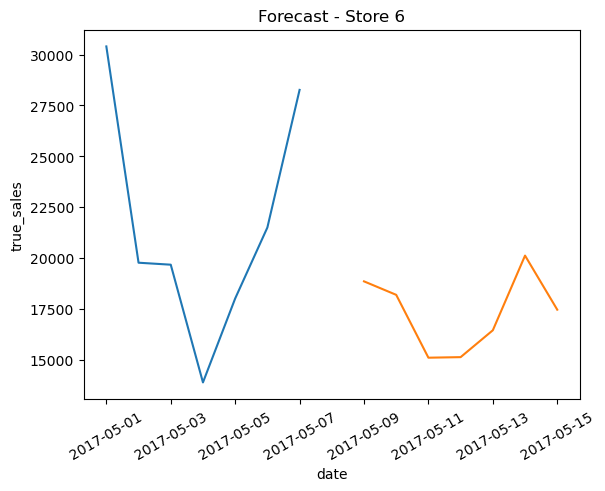

In [197]:
# plot the predictions
plot_title = "Forecast - Store {}".format(store_nbr)
sns.lineplot(data=store_forecast[:7], x='date', y='true_sales').set(title=plot_title)
sns.lineplot(data=store_forecast[8:], x='date', y='predicted_sales')
plt.xticks(rotation=30)
plt.show()